# Main Analysis Pipeline

In [1]:
import sys
sys.path.insert(0, '../modules')
from hits import CDCHits, CTHHits, CDCHits, FlatHits
from memory_profiler import memory_usage
from pprint import pprint
from collections import Counter
from root_numpy import list_branches
%load_ext memory_profiler
from tracking import HoughSpace
from scipy import sparse
from tracking import HoughTransformer, HoughShifter
from cylinder import CDC

# Convenience Functions

In [2]:
# The most common are stored in these notebooks
%run visualizations.ipynb
%run data_tools.ipynb

Populating the interactive namespace from numpy and matplotlib


In [3]:
def set_additional_branches(sample, row_name=None, cell_id=None, relative_time=None):
    """
    Set the trigger time and cell ID branches
    """
    if row_name:
        sample.data[row_name] = sample.geom.get_layers(sample.data[sample.flat_name])
    if cell_id:
        sample.data[cell_id] = sample.geom.get_indexes(sample.data[sample.flat_name])
    if relative_time:
        sample.data[relative_time] = sample.data[sample.time_name] - sample.data[sample.trig_name]

## Access data

In [4]:
def get_measurment_and_neighbours(hit_sample, measurement, events=None):
    """
    Get the measurement on the wire and its neighbours in a classification-friendly way
    
    :return: a list of three numpy arrays of measurement 1) on wire, 2) to left, 3) to right
    """
    return [hit_sample.get_measurement(measurement, 
                                       events, 
                                       shift=i, 
                                       only_hits=True, 
                                       flatten=True) 
                for i in [0,-1,1]]

## Import the Signal Hits

In [5]:
def test_labelling(hit_sample, sig_name, momentum_name, value):
    current_labels = hit_sample.get_events()[sig_name]
    momentum_magnitude = np.sqrt(np.square(hit_sample.get_events()[momentum_name+'.fX']) +\
                                 np.square(hit_sample.get_events()[momentum_name+'.fY']) +\
                                 np.square(hit_sample.get_events()[momentum_name+'.fZ']))
    pid_values = hit_sample.get_events()[pid_name]
    new_labels = np.logical_and(momentum_magnitude > value, pid_values == 11)
    print("Number of signal now : {}".format(sum(current_labels)))
    print("Number of signal actual : {}".format(sum(new_labels)))
    print("Number mislabelled : {}".format(hit_sample.n_hits - sum(current_labels == new_labels)))

### Make cuts

In [6]:
def remove_coincidence(hit_samp, remove_hits=True):
    # Sort by local score name
    hit_samp.sort_hits(lcl_scr_name, ascending=False)
    all_hits_keep = hit_samp.get_measurement(hit_samp.hits_index_name, only_hits=True)
    # Make a mask   
    hit_samp.data[take_hit_name][all_hits_keep.astype(int)] = 1
    # Remove the hits
    if remove_hits:
        hit_samp.trim_hits(take_hit_name, values=1)
        hit_samp.sort_hits(hit_samp.flat_name)

## Define Our Samples

In [7]:
# Define some branches to import
## Existing branches
prefix = "CDCHit.f"
drift_name = prefix + "DriftTime"
track_id_name = prefix + "Track.fTrackID"


## Branches to be filled
row_name = prefix +"Layers"
cell_id_name = prefix + "CellID"
rel_time_name = prefix + "Relative_Time"
take_hit_name = prefix + "Take_Hit"
lcl_scr_name = prefix + "Local_Score"
ngh_scr_name = prefix + "Neigh_Score"
hgh_scr_name = prefix + "Hough_Score"
trk_scr_name = prefix + "Track_Score"

empty_branches = [row_name, 
                  cell_id_name,
                  rel_time_name]

drift_dist_name = prefix + "DriftDist"
turn_id_name = prefix + "TurnID"
pid_name = prefix + "Track.fPID"
parent_track_id_name = prefix + "Track.fParentTrackID"
all_momentum_names = [ prefix + "Track.f" + st_sp + "Momentum.f" + coor 
                       for st_sp in ["Start", "Stop"] for coor in ["X", "Y", "Z"] ]
all_pos_names = [ prefix + "Track.f" + st_sp + "PosGlobal.f" + coor 
                       for st_sp in ["Start", "Stop"] for coor in ["P.fX", "P.fY", "P.fZ", "E"] ]
hit_pos_names = [ prefix + "MCPos.f" + coor for coor in ["P.fX", "P.fY", "P.fZ", "E"] ]
hit_mom_names = [ prefix + "MCMom.f" + coor for coor in ["X", "Y", "Z"] ]

# For track fitting
truth_branches = [turn_id_name, 
                   drift_dist_name,
                   pid_name,
                   parent_track_id_name] +\
                  hit_mom_names +\
                  all_momentum_names +\
                  all_pos_names +\
                  hit_pos_names

In [8]:
these_branches = dict()
these_branches["CDC"] = [drift_name, 
                         track_id_name] + truth_branches
these_branches["CTH"] = None

In [9]:
file_root = "/home/five4three2/development/ICEDUST/"\
            "track-finding-yandex/data/"
back_samples = ["batch_2_TrkTree_2500.root",
                "batch_3_TrkTree_2536.root",
                "batch_4_TrkTree_5250.root"]
sig_samples = ["oa_xx_xxx_09000000-0000_pdevedxn64ot_user-TrkTree_000_500signal-label.root",
               "oa_xx_xxx_09100000-0000_skzt2l7sdqvx_user-TrkTree_000_500signal-label.root",
               "oa_xx_xxx_09200000-0000_x67rltrbhc3n_user-TrkTree_000_500signal-label.root",
               "oa_xx_xxx_09300000-0000_seae7w5z6fvt_user-TrkTree_000_500signal-label.root",
               "oa_xx_xxx_09400000-0000_o774i4trtmim_user-TrkTree_000_500signal-label.root",
               "oa_xx_xxx_09500000-0000_ufkycd74hb4i_user-TrkTree_000_500signal-label.root"]
back_samples = [file_root + this_file for this_file in back_samples]
sig_samples = [file_root + this_file for this_file in sig_samples]

## Import the Data

In [10]:
%run data_tools.ipynb

In [11]:
train = data_import_file(sig_samples[-1],
                         use_cuts=["500","Trig","Track"],
                         branches=these_branches,
                         empty_branches=empty_branches)
set_additional_branches(train.cdc, 
                        row_name=row_name, 
                        cell_id=cell_id_name, 
                        relative_time=rel_time_name)

pos = list()
pos += ["MCPos.fP.fX"]
pos += ["MCPos.fP.fY"]
pos += ["MCPos.fP.fZ"]

p = dict()
p["cdc"] = dict()
p["cdc"]["x"] =  train.cdc.prefix + pos[2]
p["cdc"]["y"] =  train.cdc.prefix + pos[1]
p["cdc"]["z"] =  train.cdc.prefix + pos[0]

train.cdc.data[p["cdc"]["x"]] = - (train.cdc.data[p["cdc"]["x"]]/10. - 765)
train.cdc.data[p["cdc"]["y"]] = train.cdc.data[p["cdc"]["y"]]/10.
train.cdc.data[p["cdc"]["z"]] = (train.cdc.data[p["cdc"]["z"]]/10. - 641)

Using cuts
{ 'CDC': 'CDCHit.fDetectedTime < 1620 && CDCHit.fDetectedTime > 500 && CDCHit.fGoodTrig == 1 && CDCHit.fGoodTrack == 1',
  'CTH': 'CTHHit.fMCPos.fE < 1620 && CTHHit.fMCPos.fE > 500 && CTHHit.fGoodTrig == 1 && CTHHit.fGoodTrack == 1'}
Getting branches
{'CDC': ['CDCHit.fDriftTime',
         'CDCHit.fTrack.fTrackID',
         'CDCHit.fTurnID',
         'CDCHit.fDriftDist',
         'CDCHit.fTrack.fPID',
         'CDCHit.fTrack.fParentTrackID',
         'CDCHit.fMCMom.fX',
         'CDCHit.fMCMom.fY',
         'CDCHit.fMCMom.fZ',
         'CDCHit.fTrack.fStartMomentum.fX',
         'CDCHit.fTrack.fStartMomentum.fY',
         'CDCHit.fTrack.fStartMomentum.fZ',
         'CDCHit.fTrack.fStopMomentum.fX',
         'CDCHit.fTrack.fStopMomentum.fY',
         'CDCHit.fTrack.fStopMomentum.fZ',
         'CDCHit.fTrack.fStartPosGlobal.fP.fX',
         'CDCHit.fTrack.fStartPosGlobal.fP.fY',
         'CDCHit.fTrack.fStartPosGlobal.fP.fZ',
         'CDCHit.fTrack.fStartPosGlobal.fE',
       

## Implement the fitting model

In [12]:
def fit_circle_base(x, y, w=[]):
    
    A = array([x, y, ones(len(x))]).T
    b = x**2 + y**2
    
    # Modify A,b for weighted least squares
    if len(w) == len(x):
        W = diag(w)
        A = dot(W,A)
        b = dot(W,b)
    
    # Solve by method of least squares
    c = linalg.lstsq(A,b)[0]
    
    # Get circle parameters from solution c
    xc = c[0]/2
    yc = c[1]/2
    r = sqrt(c[2] + xc**2 + yc**2)
    return xc, yc, r

In [13]:
# Step 1: provide x, y data for fitting
# Step 2: Transform x, y data into linear fit space
# Step 3: Pass new data to fitter
# Step 4: Return model parameters

In [14]:
from sklearn.linear_model import RANSACRegressor, LinearRegression

In [15]:
def transform_params(model):
    xc, yc = model.coef_/2.
    r = sqrt(model.intercept_ + xc**2 + yc**2)
    return xc, yc, r

In [16]:
def is_track_valid(model, X, y):
    xc, yc, r = transform_params(model)
    t_xc, t_yc, t_r = 0, 0, 10
    return (t_r-r)**2 <= (t_xc-xc)**2 + (t_yc-yc)**2 <= (t_r+r)**2

In [46]:
# https://meshlogic.github.io/posts/jupyter/curve-fitting/fitting-a-circle-to-cluster-of-3d-points/
def fit_circle(x,y,w=[]):   
    A = array([x, y]).T
    b = x**2 + y**2
    
    # Modify A,b for weighted least squares
    if len(w) == len(x):
        W = diag(w)
        A = dot(W,A)
        b = dot(W,b)
        
    # Set the residual threshold
    resid_thresh = np.median(np.abs(b - np.median(b)))
    if resid_thresh < 1e-10:
        resid_thresh = np.mean(np.abs(b - np.mean(b)))
    # Solve by method of least squares
    a_ransac = RANSACRegressor(residual_threshold=resid_thresh,
                               is_model_valid=is_track_valid)
    a_ransac.fit(A,b)
    return transform_params(a_ransac.estimator_), a_ransac

In [47]:
def fit_cdc_wires(geom, pnt_ids):
    # Get the x and y positions of these wire IDs
    hit_xs, hit_ys = geom.point_x[pnt_ids], geom.point_y[pnt_ids]
    # Fit the circles
    ransac_fit, ransac = fit_circle(hit_xs, hit_ys)
    linear_fit, linear_model, linear_resid = fit_circle_linear(hit_xs, hit_ys)
    # Print the inlier mask
    inlier_ids = pnt_ids[ransac.inlier_mask_]
    all_wires = np.zeros(geom.n_points)
    all_wires[pnt_ids] = 2
    all_wires[inlier_ids] = 1
    return all_wires, ransac.inlier_mask_, ransac_fit, linear_fit, linear_resid

In [48]:
def fit_circle_linear(x, y, w=[]):
    # Tranform the data 
    A = array([x, y]).T
    b = x**2 + y**2
    
    # Modify A,b for weighted least squares
    if len(w) == len(x):
        W = diag(w)
        A = dot(W,A)
        b = dot(W,b)
    
    # Solve by method of least squares
    a_linear = LinearRegression()
    a_linear.fit(A,b)
    # Get the residuals 
    resid = a_linear.predict(A) - b
    return transform_params(a_linear), a_linear, resid

## Multithread the implementation

In [49]:
# Set the residual threshold:
#  * as the maximum residual of all residuals in the sample
#  * as the MAD of the entire sample
#  * as the max MAD of any event sample

In [50]:
from multiprocessing import Pool
from collections import defaultdict

In [51]:
PROJECTION = 0.5
geom = CDC(projection=PROJECTION)

In [52]:
def fit_event(event):
    # Get the wire ids we need
    pnt_ids = train.cdc.get_events(event)[train.cdc.flat_name]
    even_wires, odd_wires = train.cdc.get_hit_wires_even_odd(event)
    # Get the results for these wire ids
    a_result = list()
    for wires, label in zip([pnt_ids, even_wires, odd_wires],
                            ["all", "even", "odd"]):
        try:
            results = fit_cdc_wires(geom, wires)
            a_result.append(results)
        except ValueError as e:
            print "Bad Event for", label, event
            print e
            a_result.append(None)
    return tuple(a_result)

In [53]:
pool = Pool(32) 
all_results = pool.map(fit_event, range(train.cdc.n_events))

Bad Event for even 4334
RANSAC could not find a valid consensus set. All `max_trials` iterations were skipped because each randomly chosen sub-sample failed the passing criteria. See estimator attributes for diagnostics (n_skips*).
Bad Event for odd 5344
RANSAC could not find a valid consensus set. All `max_trials` iterations were skipped because each randomly chosen sub-sample failed the passing criteria. See estimator attributes for diagnostics (n_skips*).


In [55]:
# list of tuples with (all, even, odd) all_wires, ransac.inlier_mask_, ransac_fit, linear_fit, linear_resid
dict_result = defaultdict(lambda: defaultdict(list))

for result_set in all_results:
    for wire_results, even_odd in zip(result_set, ["all", "even", "odd"]):
        if wire_results is None:
            wire_results = (None, None, None, None, None)
        for result_type, res_name in zip(wire_results, ["wire_ids", "inlier_mask", "ransac_fit", 
                                                        "linear_fit", "linear_residuals"]):
            dict_result[res_name][even_odd].append(result_type)

Event 5344
Projection 0.5
2.75038847673 29.0622812032 27.0461376727
2.75038847673 29.0622812032 27.0461376727
2.75038847673 29.0622812032 27.0461376727
2.75038847673 29.0622812032 27.0461376727


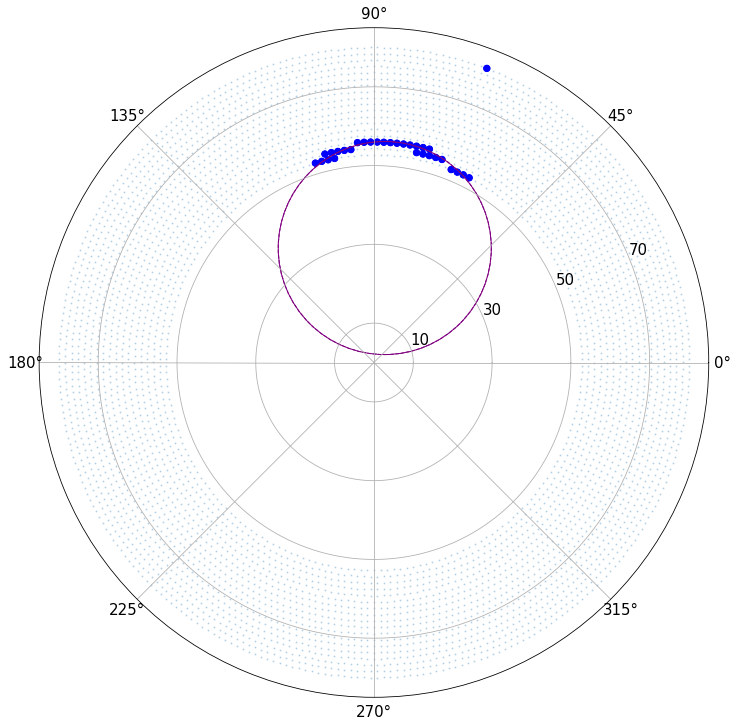

In [57]:
# Event information
for event in [5344]:
    to_plot = np.take([0,2,1], train.cdc.get_measurement("CDCHit.fIsSig", 
                                                         events=event, 
                                                         default=-1, 
                                                         only_hits=False,
                                                         flatten=True).astype(int) + 1)
    cdc_hits = train.cdc.get_events(event)
    for projection in [PROJECTION]:
        # Print the current parameters
        print "Event " + str(event)
        print "Projection " + str(projection)
        # Set the geometry
        geom = CDC(projection=projection)
        # Get the wire ids we need
        pnt_ids = train.cdc.get_events(event)[train.cdc.flat_name]
        even_wires, odd_wires = train.cdc.get_hit_wires_even_odd(event)
        # Plot this output
        plot_output(to_plot, geom)
        plot_add_outlines(to_plot, geom)
        for even_odd, color in zip(["even", "odd"], ["Purple", "Orange"]):
            # Draw the fits
            for res_name, ls in zip(["ransac_fit", "linear_fit"], ["--", "-"]):
                fit = dict_result[res_name][even_odd][event]
                if fit is not None:
                    xc, yc, r = fit
                    plot_add_circle(xc, yc, r, ls=ls, color=color)
                print xc, yc, r
        plt.show()
        #plt.scatter(cdc_hits[p["cdc"]["x"]], 
        #            cdc_hits[p["cdc"]["y"]], 
        #            s=1, color="black",
        #            transform=gca().transData._b)

## Score the Model

In [67]:
# Print the average number of outliers
for wires, masks in dict_result["inlier_mask"].items():
    value = 0
    total = 0
    for a_mask in masks:
        if a_mask is not None:
            value += sum(~a_mask)
            total += len(a_mask)
    print wires, value, total

even 2700 252824
all 44587 646846
odd 3114 246359


## Scraps

In [54]:
pnt_ids = train.cdc.get_events(5291)[train.cdc.flat_name]
even_wires, odd_wires = train.cdc.get_hit_wires_even_odd(5291)
pnt_ids = odd_wires
# Get the x and y positions of these wire IDs
x, y = geom.point_x[pnt_ids], geom.point_y[pnt_ids]
# Fit the circles
A = array([x, y]).T
b = x**2 + y**2

print(b)
resid_thresh = np.median(np.abs(b - np.median(b)))
print(resid_thresh)

# Solve by method of least squares
a_ransac = RANSACRegressor(max_trials=10000, residual_threshold=resid_thresh)
a_ransac.fit(A,b)
print(a_ransac.max_skips)
print(a_ransac.max_trials)
print(a_ransac.n_skips_invalid_data_)
print(a_ransac.n_skips_invalid_model_)
print(a_ransac.n_skips_no_inliers_)
print(a_ransac.n_trials_)

[ 2955.77992457  2955.77992457  2955.77992457  2955.77992457  2955.77992457
  2955.77992457  3315.46254509  3315.46254509  3315.46254509  3315.46254509
  3315.46254509  3315.46254509  3315.46254509  3315.46254509  3315.46254509
  3315.46254509]
0.0


ValueError: RANSAC could not find a valid consensus set. All `max_trials` iterations were skipped because each randomly chosen sub-sample failed the passing criteria. See estimator attributes for diagnostics (n_skips*).